In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import cv2
import os
from os import listdir
import re
import gc
import random
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm.auto import tqdm
from pprint import pprint
from time import time
import itertools
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nibabel as nib
from glob import glob
import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=UserWarning)
#warnings.filterwarnings("ignore", category=FutureWarning)
import zipfile
from scipy import ndimage
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
from PIL import Image
from dipy.denoise.nlmeans import nlmeans
from dipy.denoise.noise_estimate import estimate_sigma
from skimage import exposure

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import kornia
import kornia.augmentation as augmentation

In [2]:
def interpolate_volume(volume, vol_size=None):
    volume = torch.tensor(volume, dtype=torch.float32)
    vol_shape = tuple(volume.shape)
    if not vol_size:
        d_new = min(vol_shape[:2])
        vol_size = (vol_shape[0], vol_shape[1], d_new)
    if vol_shape == vol_size:
        return volume.numpy()
    interpolated = F.interpolate(volume.unsqueeze(0).unsqueeze(0), size=vol_size, mode="trilinear", align_corners=False)[0, 0]

    return interpolated.numpy()

### Reproducibility

In [3]:
# Set random seeds
def set_seed(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
set_seed()

# Config

In [4]:
# Hyperparameters
BATCH_SIZE = 4
LEARNING_RATE = 0.0001
N_EPOCHS = 20
PATIENCE = 3
EXPERIMENTAL = False
AUGMENTATIONS = True

# Config device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data

### Load tables

In [7]:
# Load metadata
train_df = pd.read_csv("/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train.csv")
train_bbox = pd.read_csv("/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")
test_df = pd.read_csv("/kaggle/input/rsna-2022-cervical-spine-fracture-detection/test.csv")
ss = pd.read_csv("/kaggle/input/rsna-2022-cervical-spine-fracture-detection/sample_submission.csv")

# Print dataframe shapes
print('train shape:', train_df.shape)
print('train bbox shape:', train_bbox.shape)
print('test shape:', test_df.shape)
print('ss shape:', ss.shape)
print('')

# Show first few entries
train_df.head(3)

train shape: (2019, 9)
train bbox shape: (7217, 6)
test shape: (3, 3)
ss shape: (3, 2)



,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0


### Drop bad scans

In [10]:
# https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/344862
bad_scans = ['1.2.826.0.1.3680043.20574','1.2.826.0.1.3680043.29952']

for uid in bad_scans:
    train_df.drop(train_df[train_df['StudyInstanceUID']==uid].index, axis=0, inplace=True)

### Debug

In [13]:
debug = False
if len(ss) == 3:
    debug = True
    
    # Fix mismatch with test_images folder
    test_data = []
    for i in ['1.2.826.0.1.3680043.22327', '1.2.826.0.1.3680043.25399', '1.2.826.0.1.3680043.5876']:
        for j in ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'patient_overall']:
            test_data.append({'row_id': i + '_' + j, 'StudyInstanceUID': i, 'prediction_type': j})
    
    # Creating the DataFrames
    test_df = pd.DataFrame(test_data)
    ss = pd.DataFrame(test_df['row_id'])
    ss['fractured'] = 0.5
    
    display(test_df.head(3))

In [14]:
test_df

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.22327_C1,1.2.826.0.1.3680043.22327,C1
1,1.2.826.0.1.3680043.22327_C2,1.2.826.0.1.3680043.22327,C2
2,1.2.826.0.1.3680043.22327_C3,1.2.826.0.1.3680043.22327,C3
3,1.2.826.0.1.3680043.22327_C4,1.2.826.0.1.3680043.22327,C4
4,1.2.826.0.1.3680043.22327_C5,1.2.826.0.1.3680043.22327,C5
5,1.2.826.0.1.3680043.22327_C6,1.2.826.0.1.3680043.22327,C6
6,1.2.826.0.1.3680043.22327_C7,1.2.826.0.1.3680043.22327,C7
7,1.2.826.0.1.3680043.22327_patient_overall,1.2.826.0.1.3680043.22327,patient_overall
8,1.2.826.0.1.3680043.25399_C1,1.2.826.0.1.3680043.25399,C1
9,1.2.826.0.1.3680043.25399_C2,1.2.826.0.1.3680043.25399,C2


# Augmentations

Ideas: rotation/flip in x-y plane. Small deformations. Some scans are contained in circle, others aren't. Maybe apply a mask to be consistent. 

In [15]:
# Data augmentations (https://kornia.readthedocs.io/en/latest/augmentation.module.html#geometric)
if AUGMENTATIONS:
    augs = transforms.Compose([
        augmentation.RandomRotation3D((0,0,30), resample='bilinear', p=0.5, same_on_batch=False, keepdim=True),
        #augmentation.RandomHorizontalFlip3D(same_on_batch=False, p=0.5, keepdim=True),
        ])
else:
    augs=None

### Visualise augmentations

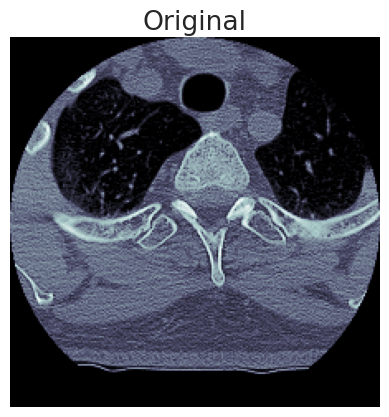

In [17]:
path = '/kaggle/input/rsna-3d-train-tensors-second-half/train_volumes/1.2.826.0.1.3680043.10443.pt'
vol = torch.load(path).to(torch.float32)
plt.imshow(vol[60,:,:], cmap='bone')
plt.axis('off')
plt.title('Original')
plt.show()

In [22]:
vol.shape

torch.Size([224, 224, 224])

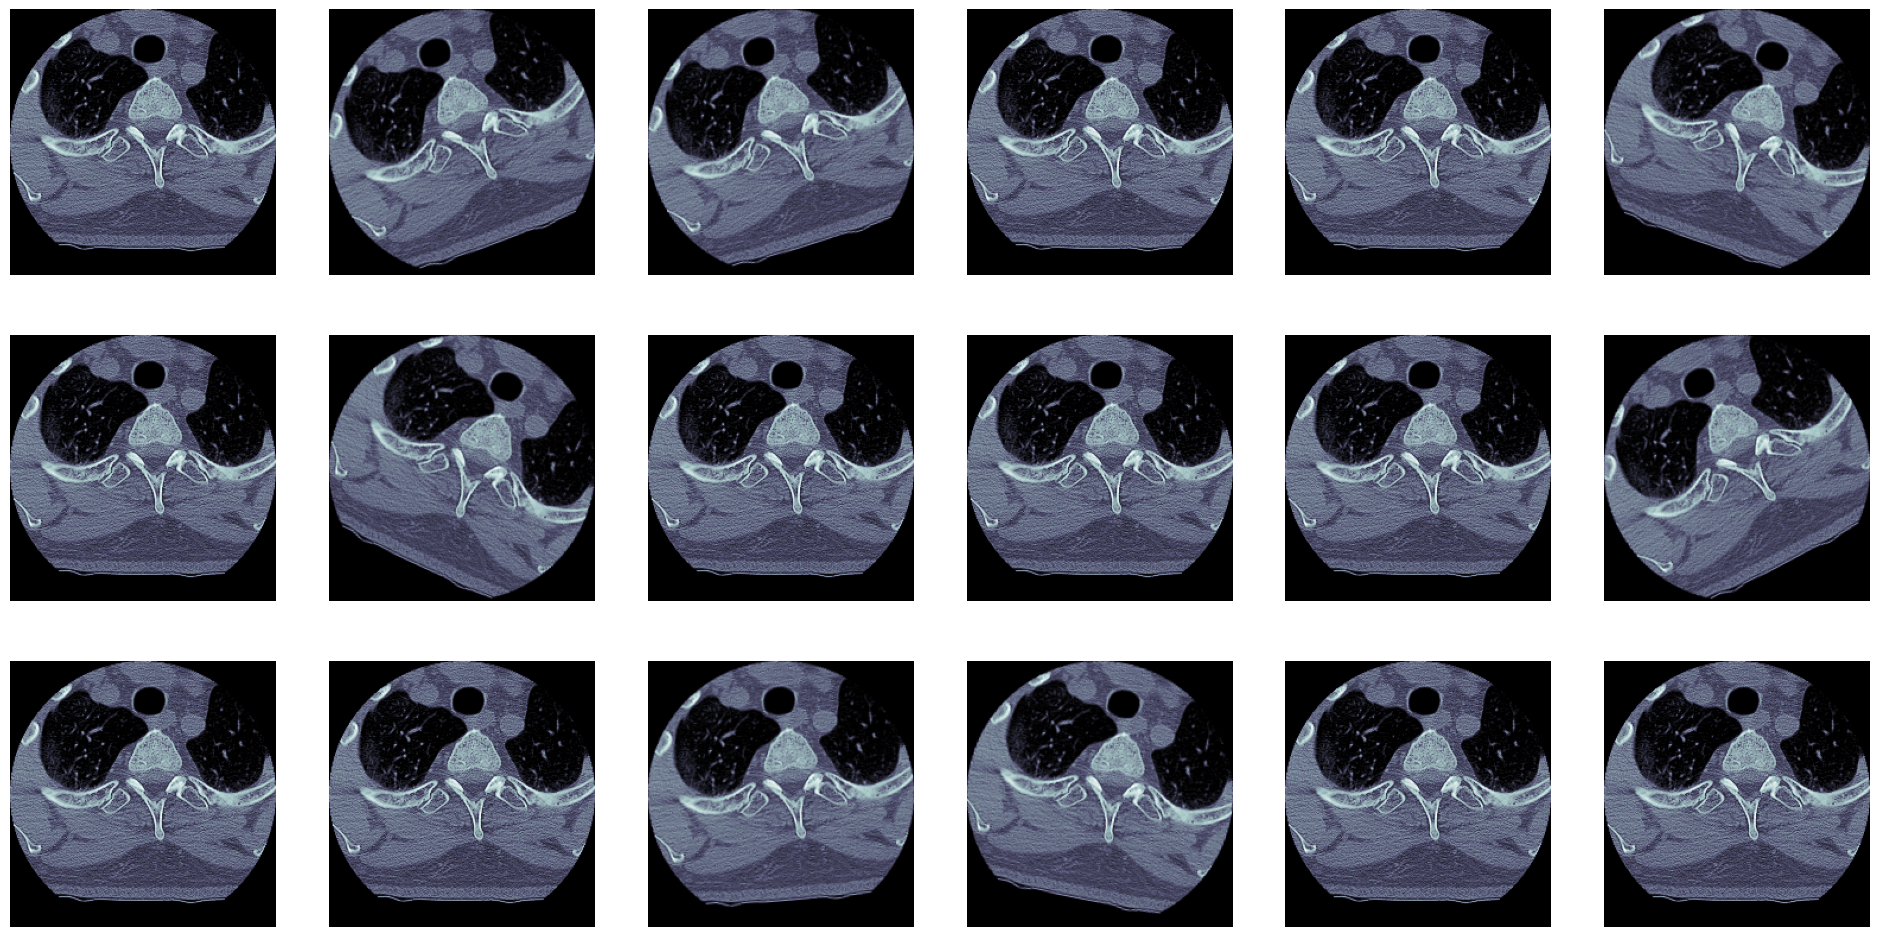

In [23]:
# Plot images
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))

for i in range(18):
    vol2 = augs(vol)

    # Plot the image
    x = i // 6
    y = i % 6

    axes[x, y].imshow(vol2[60,:,:], cmap="bone")
    axes[x, y].axis('off')

# Torch dataset

In [58]:
# Dataset for train/valid sets only
class RSNADataset(Dataset):
    # Initialise
    def __init__(self, subset='train', df_table = train_df, transform=None):
        super().__init__()
        
        self.subset = subset
        self.df_table = df_table.reset_index(drop=True)
        self.transform = transform
        self.targets = ['C1','C2','C3','C4','C5','C6','C7','patient_overall']
        
        # Identify files in each of the two datasets
        fh_paths = glob(os.path.join('/kaggle/input/rsna-3d-train-tensors-first-half/train_volumes', "*.pt"))
        sh_paths = glob(os.path.join('/kaggle/input/rsna-3d-train-tensors-second-half/train_volumes', "*.pt"))
        
        fh_list = []
        sh_list = []
        for i in fh_paths:
            fh_list.append(i.split('/')[-1][:-3])
        
        for i in sh_paths:
            sh_list.append(i.split('/')[-1][:-3])
        
        self.df_table_fh = self.df_table[self.df_table['StudyInstanceUID'].isin(fh_list)]
        self.df_table_sh = self.df_table[self.df_table['StudyInstanceUID'].isin(sh_list)]
        
        # Image paths
        self.volume_dir1 = '/kaggle/input/rsna-3d-train-tensors-first-half/train_volumes'  # <=1000 patient
        self.volume_dir2 = '/kaggle/input/rsna-3d-train-tensors-second-half/train_volumes' # >1000 patient

        # Populate labels
        self.labels = self.df_table[self.targets].values
        
    # Get item in position given by index
    def __getitem__(self, index):
        if index in self.df_table_fh.index:
            patient = self.df_table_fh[self.df_table_fh.index==index]['StudyInstanceUID'].iloc[0]
            path = os.path.join(self.volume_dir1, f"{patient}.pt")
            vol = torch.load(path).to(torch.float32)
        else:
            patient = self.df_table_sh[self.df_table_sh.index==index]['StudyInstanceUID'].iloc[0]
            path = os.path.join(self.volume_dir2, f"{patient}.pt")
            vol = torch.load(path).to(torch.float32)
        
        # Data augmentations
        if self.transform:
            vol = self.transform(vol)
        
        return vol.unsqueeze(0), self.labels[index]

    # Length of dataset
    def __len__(self):
        return len(self.df_table['StudyInstanceUID'])

In [59]:
# Train/valid datasets
experimental=EXPERIMENTAL
if experimental:
    train_table, valid_table = train_test_split(train_df, train_size=0.1, test_size=0.01, random_state=0)
    train_dataset = RSNADataset(subset='train', df_table = train_table, transform=augs)
    valid_dataset = RSNADataset(subset='valid', df_table = valid_table)
else:
    train_table, valid_table = train_test_split(train_df, train_size=0.85, test_size=0.15, random_state=0)
    train_dataset = RSNADataset(subset='train', df_table = train_table, transform=augs)
    valid_dataset = RSNADataset(subset='valid', df_table = valid_table)

In [65]:
train_dataset[0][0].shape

torch.Size([1, 224, 224, 224])

# Torch dataloaders

In [66]:
# Dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model

conv output size = floor((W-F+2P)/S + 1)

In [ ]:
# Experiment with architecture
'''
arr = np.ones((4,1,224,224,224))
x = torch.tensor(arr, dtype=torch.float32)

conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=7, stride=1, padding=0)
pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
norm1 = nn.BatchNorm3d(num_features=16)
conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
norm2 = nn.BatchNorm3d(num_features=32)
conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
norm3 = nn.BatchNorm3d(num_features=64)
avg = nn.AdaptiveAvgPool3d((7, 1, 1))
flat = nn.Flatten()
relu = nn.ReLU()
lin1 = nn.Linear(in_features=32*13*13*13, out_features=256)
lin2 = nn.Linear(in_features=256, out_features=8)

out = conv1(x)
out = relu(out)
out = pool(out)
out = norm1(out)
print(out.shape)

out = conv2(out)
out = relu(out)
out = pool(out)
out = norm2(out)
print(out.shape)

out = conv3(out)
out = relu(out)
out = pool(out)
out = norm3(out)
print(out.shape)

out = avg(out)
print(out.shape)
out = flat(out)
print(out.shape)
'''

In [69]:
# 3D convolutional neural network
class Conv3DNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Layers
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=7, stride=1, padding=0)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.norm1 = nn.BatchNorm3d(num_features=16)
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.norm2 = nn.BatchNorm3d(num_features=32)
        self.conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.norm3 = nn.BatchNorm3d(num_features=64)
        self.avg = nn.AdaptiveAvgPool3d((7, 1, 1))
        self.flat = nn.Flatten()
        self.relu = nn.ReLU()
        self.lin1 = nn.Linear(in_features=448, out_features=128)
        self.lin2 = nn.Linear(in_features=128, out_features=8)
        
    def forward(self, x):
        # Conv block 1
        out = self.conv1(x)
        out = self.relu(out)
        out = self.pool(out)
        out = self.norm1(out)
        
        # Conv block 2
        out = self.conv2(out)
        out = self.relu(out)
        out = self.pool(out)
        out = self.norm2(out)
        
        # Conv block 3
        out = self.conv3(out)
        out = self.relu(out)
        out = self.pool(out)
        out = self.norm3(out)
        
        # Average & flatten
        out = self.avg(out)
        out = self.flat(out)
        
        # Fully connected layer
        out = self.lin1(out)
        out = self.relu(out)
        
        # Output layer (no sigmoid needed)
        out = self.lin2(out)
        
        return out

model = Conv3DNet().to(device)

# Loss & optimiser

In [70]:
# Replicate competition metric (https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/341854)
loss_fn = nn.BCEWithLogitsLoss(reduction='none')

competition_weights = {
    '-' : torch.tensor([1, 1, 1, 1, 1, 1, 1, 7], dtype=torch.float, device=device),
    '+' : torch.tensor([2, 2, 2, 2, 2, 2, 2, 14], dtype=torch.float, device=device),
}

# y_hat.shape = (batch_size, num_classes)
# y.shape = (batch_size, num_classes)

# with row-wise weights normalization (https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/344565)
def competiton_loss_row_norm(y_hat, y):
    loss = loss_fn(y_hat, y.to(y_hat.dtype))
    weights = y * competition_weights['+'] + (1 - y) * competition_weights['-']
    loss = (loss * weights).sum(axis=1)
    w_sum = weights.sum(axis=1)
    loss = torch.div(loss, w_sum)
    return loss.mean()

In [71]:
# Adam optimiser
optimiser = optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimiser, T_max=N_EPOCHS)

# Train model

In [72]:
loss_hist = []
val_loss_hist = []
patience_counter = 0
best_val_loss = np.inf

# Loop over epochs
for epoch in tqdm(range(N_EPOCHS)):
    loss_acc = 0
    val_loss_acc = 0
    train_count = 0
    valid_count = 0
    
    # Loop over batches
    for imgs, labels in train_loader:
        # Send to device
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward pass
        preds = model(imgs)
        L = competiton_loss_row_norm(preds, labels)

        # Backprop
        L.backward()

        # Update parameters
        optimiser.step()

        # Zero gradients
        optimiser.zero_grad()
        
        # Track loss
        loss_acc += L.detach().item()
        train_count += 1
    
    # Update learning rate
    scheduler.step()
    
    # Don't update weights
    with torch.no_grad():
        # Validate
        for val_imgs, val_labels in valid_loader:
            # Reshape
            val_imgs = val_imgs.to(device)
            val_labels = val_labels.to(device)

            # Forward pass
            val_preds = model(val_imgs)
            val_L = competiton_loss_row_norm(val_preds,val_labels)
            
            # Track loss
            val_loss_acc += val_L.item()
            valid_count += 1
    
    # Save loss history
    loss_hist.append(loss_acc/train_count)
    val_loss_hist.append(val_loss_acc/valid_count)
    
    # Print loss
    if (epoch+1)%1==0:
        print(f'Epoch {epoch+1}/{N_EPOCHS}, loss {loss_acc/train_count:.5f}, val_loss {val_loss_acc/valid_count:.5f}')
    
    # Save model (& early stopping)
    if (val_loss_acc/valid_count) < best_val_loss:
        best_val_loss = val_loss_acc/valid_count
        patience_counter=0
        print('Valid loss improved --> saving model')
        torch.save({
                    'epoch': epoch+1,
                    'model_state_dict': model.state_dict(),
                    'optimiser_state_dict': optimiser.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'loss': loss_acc/train_count,
                    'val_loss': val_loss_acc/valid_count,
                    }, "Conv3DNet.pt")
    else:
        patience_counter+=1
        
        if patience_counter==PATIENCE:
            break
        
print('')
print('Training complete!')

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Learning curves

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(loss_hist, c='C0', label='loss')
plt.plot(val_loss_hist, c='C1', label='val_loss')
plt.title('Competition metric')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()